In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from os import getcwd, listdir, mkdir
from os.path import join
import matplotlib.pyplot as plt
import mido

In [2]:
def parse_csv(file):
    dataset_parsed = tf.data.TextLineDataset(file).skip(1)
    defaults = [0]*4
    dataset_parsed = dataset_parsed.map(lambda line: tf.stack(tf.io.decode_csv(line, defaults)))
    eof = tf.data.Dataset.from_tensor_slices([-1,-1,-1,-1]).batch(4)
    dataset_parsed = dataset_parsed.concatenate(eof)
    dataset_parsed = dataset_parsed.unbatch()
    return dataset_parsed
    
def load_partition(partition='train'):
    filename = listdir(join(getcwd(), 'bach-chorales', partition))
    files = []
    for file in filename:
        files.append(join(getcwd(), 'bach-chorales', partition, file))
    dataset = tf.data.Dataset.list_files(files)
    dataset = dataset.flat_map(parse_csv) # flat_map ~ simple interleave
    return dataset

def one_hot_encoding(note):
    vector = np.zeros((81-36+3))
    if note == -1: # eof
        vector[0] = 1
    elif note == 0: # silence
        vector[1] = 1
    elif note >= 36 and note <= 81:
        vector[note-36+2] = 1
    else:
        raise Exception('invalid note, should be either -1 (eof), 0 (silence), or [36,81]')
    return vector

def make_dataset(partition='train'):
    dataset = list(load_partition(partition).as_numpy_iterator())
    x = dataset[:-1]
    y = dataset[1:]
    x_encoded = [one_hot_encoding(note) for note in x]
    y_encoded = [one_hot_encoding(note) for note in y]
    dataset = tf.data.Dataset.from_tensor_slices((x_encoded,y_encoded))
    return dataset

def one_hot_decoding(vector):
    if vector.flatten()[0] == 1: # eof
        note = -1
    elif vector.flatten()[1] == 1: # silence
        note = 0
    else:
        note = vector.flatten().argmax() + 36 - 2
    return note

In [3]:
train, valid, test = make_dataset('train'), make_dataset('valid'), make_dataset('test')

In [278]:
# model 2 .53 @test
#model = keras.models.Sequential()
#model.add(keras.layers.GRU(96, dropout = .1, recurrent_dropout = .1, input_shape = [None, 48], return_sequences = True))
#model.add(keras.layers.GRU(96, dropout = .1, recurrent_dropout = .1, return_sequences = True))
#model.add(keras.layers.GRU(96, dropout = .1, recurrent_dropout = .1, return_sequences = True))
#model.add(keras.layers.Dense(48, kernel_regularizer = keras.regularizers.l2(l2=0)))
#model.add(keras.layers.Dropout(.1))
#model.add(keras.layers.Activation('softmax'))

# model 3 - .34 @train, .53 @valid, .54 @test, without much tinkering
model = keras.models.Sequential()
model.add(keras.layers.GRU(96, dropout = .1, recurrent_dropout = .1, input_shape = [None, 48], return_sequences = True))
model.add(keras.layers.GRU(96, dropout = .1, recurrent_dropout = .1, return_sequences = True))
model.add(keras.layers.GRU(96, dropout = .1, recurrent_dropout = .1, return_sequences = True))
model.add(keras.layers.GRU(96, dropout = .1, recurrent_dropout = .1, return_sequences = True))
model.add(keras.layers.Dense(48, kernel_regularizer = keras.regularizers.l2(l2=0)))
model.add(keras.layers.Dropout(.1))
model.add(keras.layers.Activation('softmax'))

In [285]:
learning_rate = 0.0001 # 0.01 -> 0.001 -> 0.0001
sequence_length = 256 # 256
batch_size = 16 # 16 -> 16 -> 64

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer=optimizer, loss = 'categorical_crossentropy')

early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, verbose=True)

# PROBABLY SHOULDN'T BATCH THE VALIDATION SET! longer sequences tend to provide better prediction...

history = model.fit(train.batch(sequence_length).batch(batch_size, drop_remainder=True).cache(),
                    epochs = 1000,
                    validation_data = valid.batch(sequence_length).batch(batch_size, drop_remainder=True).cache(),
                    callbacks = [early_stopping])

Epoch 1/1000
54/54 [==============================] - 194s 4s/step - loss: 0.6582 - val_loss: 0.5330
Epoch 2/1000
54/54 [==============================] - 194s 4s/step - loss: 0.6548 - val_loss: 0.5332
Epoch 3/1000
54/54 [==============================] - 190s 4s/step - loss: 0.6574 - val_loss: 0.5332
Epoch 4/1000
54/54 [==============================] - 190s 4s/step - loss: 0.6564 - val_loss: 0.5330
Epoch 5/1000
54/54 [==============================] - 195s 4s/step - loss: 0.6600 - val_loss: 0.5328
Epoch 6/1000
54/54 [==============================] - 191s 4s/step - loss: 0.6558 - val_loss: 0.5331
Epoch 7/1000
54/54 [==============================] - 189s 3s/step - loss: 0.6554 - val_loss: 0.5333
Epoch 8/1000
54/54 [==============================] - 190s 4s/step - loss: 0.6569 - val_loss: 0.5332
Epoch 9/1000
54/54 [==============================] - 185s 3s/step - loss: 0.6534 - val_loss: 0.5330
Epoch 10/1000
54/54 [==============================] - 183s 3s/step - loss: 0.6540 - val_lo

In [286]:
model.evaluate(train.batch(sequence_length).batch(batch_size, drop_remainder=True))

54/54 [==============================] - 31s 570ms/step - loss: 0.3473


0.3473449647426605

In [287]:
model.evaluate(valid.batch(sequence_length).batch(batch_size, drop_remainder=True))

18/18 [==============================] - 10s 544ms/step - loss: 0.5319


0.5318822860717773

In [288]:
model.evaluate(test.batch(sequence_length).batch(batch_size, drop_remainder=True))

18/18 [==============================] - 10s 536ms/step - loss: 0.5420


0.5420477390289307

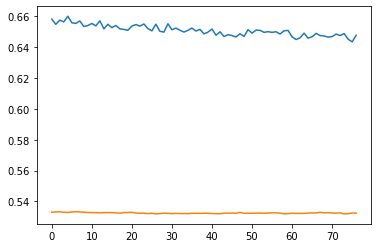

In [289]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [290]:
# music generation

Length = 800 # number of new notes on all voices, actual piece length is Length/4
Temperature = 1.0 # not really temperature (which should be applied before softmax), but works similarly (smaller values are more adventurous, larger values are more conservative)

song = []
song_encoded = one_hot_encoding(-1).reshape((1,1,48)).repeat(16, axis=1)
song_encoded.shape

new_note = -1
new_note_encoding = one_hot_encoding(new_note).reshape((1,1,48))

# music generation loop

for _ in range(Length):
    p = model.predict(song_encoded)[:,-1,:].flatten() # the model is reading the entire chorale up to this point, which makes it very slow for long sequences. This should be improved, providing a limited number os samples for each new note or making the network remember the last state.
    p = p**Temperature / (p**Temperature).sum()
    
    out = np.random.choice(48, p=p)
    new_note_encoding = np.zeros((1,1,48))
    new_note_encoding[0,0,out] = 1
    new_note = one_hot_decoding(new_note_encoding)

    song.append(new_note)
    extended_song = np.zeros((song_encoded.shape[0], song_encoded.shape[1]+1, song_encoded.shape[2]))
    extended_song[:,:-1,:] = song_encoded
    extended_song[:,-1,:] = new_note_encoding
    song_encoded = extended_song

In [291]:
np.array(song).reshape((-1,4,4))

array([[[65, 60, 57, 53],
        [65, 60, 57, 53],
        [67, 62, 58, 53],
        [67, 62, 58, 53]],

       [[69, 63, 60, 53],
        [69, 63, 60, 53],
        [69, 62, 60, 53],
        [69, 62, 60, 53]],

       [[70, 62, 58, 55],
        [70, 62, 58, 55],
        [70, 62, 57, 55],
        [70, 62, 57, 55]],

       [[72, 60, 55, 51],
        [72, 60, 55, 51],
        [72, 70, 55, 51],
        [72, 69, 55, 51]],

       [[72, 69, 65, 50],
        [72, 69, 65, 50],
        [72, 69, 65, 50],
        [72, 69, 65, 50]],

       [[72, 67, 63, 48],
        [72, 67, 63, 48],
        [72, 67, 63, 48],
        [72, 67, 63, 48]],

       [[74, 65, 62, 46],
        [74, 65, 62, 46],
        [74, 65, 62, 46],
        [74, 65, 62, 46]],

       [[75, 67, 58, 51],
        [75, 67, 58, 51],
        [75, 67, 58, 51],
        [75, 67, 58, 51]],

       [[72, 65, 57, 53],
        [72, 65, 57, 53],
        [72, 65, 57, 53],
        [72, 65, 57, 53]],

       [[74, 65, 58, 46],
        [74, 65, 58,

In [292]:
# clip entries before beginning

first_note_position = 0
for position, note in enumerate(song):
    if note != -1:
        first_note_position = position
        break

new_chorale = np.array(song[first_note_position : -4 + (first_note_position % 4)]).reshape(-1,4)
        
# clip entries after eof

first_eof = (new_chorale.min(axis = 1) == -1).astype('int').argmax()
if first_eof > 0:
    new_chorale = new_chorale[:first_eof, :]
        
# convert finished product to data frame

new_chorale = pd.DataFrame(new_chorale, columns=['note1','note2','note3','note4'])
new_chorale

,note1,note2,note3,note4
0,65,60,57,53
1,65,60,57,53
2,67,62,58,53
3,67,62,58,53
4,69,63,60,53
...,...,...,...,...
194,67,63,58,46
195,67,63,58,46
196,69,65,58,44
197,69,65,58,44


In [293]:
# music generation with legato (attack only when new note is different from current one)

new_chorale_midi = mido.MidiFile(type=1)

time_unit = 360
instrument = 52 # choir aahs
volume = [50, 50, 50, 50] # volume for each channel

for channel in range(4):
    track = mido.MidiTrack()
    track.append(mido.Message('program_change', channel = channel, program = instrument, time = 0))
    previous_note = 0
    steps = 1
    
    for pos, note in enumerate(new_chorale.iloc[:, channel]):
        if note == previous_note:
            steps += 1
        if note != previous_note:
            if pos != 0:
                track.append(mido.Message('note_off', channel=channel, note=previous_note, time = steps * time_unit))
            track.append(mido.Message('note_on', channel=channel, note=note, velocity=volume[channel], time=0))
            previous_note = note
            steps = 1
            
    new_chorale_midi.tracks.append(track)

new_chorale_midi.save('new_chorale.mid')

### Sandbox

In [ ]:
# model 1 - 1-layer SimpleRNN or GRU
#model = keras.models.Sequential()
#model.add(keras.layers.SimpleRNN(48, input_shape=[None,48], return_sequences=True, activation='softmax'))
#model.add(keras.layers.GRU(48, input_shape=[None,48], return_sequences=True, activation='softmax'))

# model 3 - with embedding, without encoding (will not work because of how the dataset was set up)
#model = keras.models.Sequential()
#model.add(keras.layers.Embedding(48,24)) # embedding requires integers, not one-hot
#model.add(keras.layers.GRU(48, return_sequences = True))
#model.add(keras.layers.GRU(48, return_sequences = True))
#model.add(keras.layers.GRU(48, return_sequences = True, activation = 'softmax'))

In [195]:
# music generation with 1 attack per chord (not very cool...)

#new_chorale_midi = mido.MidiFile()
#new_chorale_track = mido.MidiTrack()
#
#time_unit = 120
#instrument = 52 # choir aahs
#
## set the instrument
#for channel in range(4):
#    new_chorale_track.append(mido.Message('program_change', channel=channel, program=instrument, time=0))
#    
#for line in range(new_chorale.shape[0]):
#    notes = new_chorale.loc[line]
#    for channel, note in enumerate(notes):
#        new_chorale_track.append(mido.Message('note_on', note=note, velocity=100, channel=channel, time=0))
#        previous_note = note
#    previous_notes = notes
#    for channel, note in enumerate(notes):
#        new_chorale_track.append(mido.Message('note_off', note=previous_notes[channel], channel=channel, time=time_unit))
#        #new_chorale_track.append(mido.Message('note_on', note=note, velocity=0, channel=channel, time=time_unit))
#
#new_chorale_midi.tracks.append(new_chorale_track)
#
#new_chorale_midi.save('new_chorale.mid')